<a href="https://colab.research.google.com/github/MirianGreiner/Previsao_motivo_viagem/blob/main/Previs%C3%A3o_do_motivo_de_viagem_do_passageiro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inferindo o motivo de viagem em dados de bilhetagem eletrônica

##`Preparando o ambiente de desenvolvimento`

In [ ]:
# Importação de pacotes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
from collections import Counter
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, r2_score, confusion_matrix, classification_report, accuracy_score, plot_confusion_matrix, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize, QuantileTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, LassoCV
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import os
from google.colab import auth, drive
import sys
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Autenticação ao Google Cloud Storage 

auth.authenticate_user()

In [26]:
# Montagem do drive para download e upload de arquivos

drive.mount('/content/gdrive')
sys.path.insert(1,'/content/gdrive/My Drive/Mestrado')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#`Importação de datasets`

In [50]:
# Importação de Datasets

viagens_internas = pd.read_csv("/content/gdrive/My Drive/Mestrado/viagens_internas.csv", encoding = "utf-8", low_memory = False, sep = ';')

#`Pre-Processamento dos dados`

In [51]:
# Seleção de variáveis Tabela Trajetos

viagens = pd.DataFrame({"ID_DOMICILIO": viagens_internas["Domicilio"],
                        "ID_PESSOA": viagens_internas["Pessoa"],
                        "ID_VIAGEM": viagens_internas["Viagem"],
                        "AH_ORIGEM": viagens_internas["AH origem"],
                        "AH_DESTINO": viagens_internas["AH destino"],
                        "MOTIVO_ORIGEM": viagens_internas["motivo_origem"],
                        "MOTIVO_DESTINO": viagens_internas["motivo_destino"], 
                        "HORARIO_INICIO": viagens_internas["Hora início"],
                        "HORARIO_FIM": viagens_internas["Hora fim"],
                        "FAIXA_HORARIA": viagens_internas["Faixa horária"],
                        "MODO_TRANSPORTE": viagens_internas["DS_SH_MEIO_TRANSPORTE"],
                        "MODO_PRINCIPAL": viagens_internas["Modos agrupados"],
                        "FATOR_EXPANSÃO": viagens_internas["Fator expansão"]})

# Ordenar DataFrame por ID_DOMICILIO 

viagens.sort_values(by=['ID_DOMICILIO'], inplace = True)

In [52]:
# Revisão do formato dos dados 

viagens['HORARIO_INICIO'] = pd.to_datetime(viagens['HORARIO_INICIO'])
viagens['HORARIO_FIM'] = pd.to_datetime(viagens['HORARIO_FIM'])
viagens["FATOR_EXPANSÃO"] = viagens["FATOR_EXPANSÃO"].str.replace(',', '.')
viagens["FATOR_EXPANSÃO"] = viagens["FATOR_EXPANSÃO"].astype(float)

In [53]:
# Criação de chave ID_PESSOA + ID_DOMICÍLIO 

viagens["CHAVE"] = viagens["ID_DOMICILIO"].astype(str)+"_"+viagens["ID_PESSOA"].astype(str)

OD_2012 = viagens


In [54]:
# Ordenando o Data Frame final pelos IDs para identificar uma viagem

OD_2012.sort_values(by=['ID_DOMICILIO', 'ID_PESSOA', 'ID_VIAGEM'], inplace = True)
OD_2012.reset_index(drop=True, inplace=True)

In [56]:
# Primeira verificação: verificando se mais de uma viagem pertencem a uma mesma pessoa 

OD_2012['VERIFICAÇÃO_CHAVE'] = ""


for i in range (0, (len(OD_2012['CHAVE'])-1)):
    
    if OD_2012['CHAVE'][i] == OD_2012['CHAVE'][i+1]:
        OD_2012['VERIFICAÇÃO_CHAVE'][i] = 1
    else:
        OD_2012['VERIFICAÇÃO_CHAVE'][i] = 0
        
OD_2012['VERIFICAÇÃO_CHAVE'][len(OD_2012['CHAVE'])-1] = 0

In [57]:
# Segunda verificação: verificando se o motivo de destino da primeira viagem corresponde ao motivo de origem da viagem seguinte

OD_2012['VERIFICAÇÃO_MOTIVO'] = ""

for i in range (0, (len(OD_2012['CHAVE'])-1)):
    
    if OD_2012['VERIFICAÇÃO_CHAVE'][i] == 0:
        OD_2012['VERIFICAÇÃO_MOTIVO'][i] = 1
    else:
            if OD_2012['MOTIVO_ORIGEM'][i+1] == OD_2012['MOTIVO_DESTINO'][i]:
                OD_2012['VERIFICAÇÃO_MOTIVO'][i] = 1
                
            else:
                OD_2012['VERIFICAÇÃO_MOTIVO'][i] = 0 

In [58]:
# Criando a coluna saída_destino, que corresponde ao horário que a pessoa "finalizou" sua atividade no destino
# essa informação será utilizada no cálculo da duração da atividade

OD_2012['SAIDA_DESTINO'] = np.nan
OD_2012['SAIDA_DESTINO'] = pd.to_datetime(OD_2012['SAIDA_DESTINO'], format="%H:%M:%S")

for i in range (0, (len(OD_2012['CHAVE']))):
    
    if OD_2012['VERIFICAÇÃO_CHAVE'][i] == 0:
        if OD_2012['HORARIO_FIM'][i] > OD_2012['HORARIO_INICIO'][i-(OD_2012['ID_VIAGEM'][i])+1]:
            OD_2012['SAIDA_DESTINO'][i] = OD_2012['HORARIO_INICIO'][i-(OD_2012['ID_VIAGEM'][i])+1] + dt.timedelta(days=1)
        else:
            OD_2012['SAIDA_DESTINO'][i] = OD_2012['HORARIO_INICIO'][i-(OD_2012['ID_VIAGEM'][i])+1]
    else:
        if OD_2012['HORARIO_FIM'][i] > OD_2012['HORARIO_INICIO'][i+1]:
            OD_2012['SAIDA_DESTINO'][i] = OD_2012['HORARIO_INICIO'][i+1] + dt.timedelta(days=1)
        else:
            OD_2012['SAIDA_DESTINO'][i] = OD_2012['HORARIO_INICIO'][i+1]

In [59]:
# Criando a coluna saída_destino, que corresponde ao horário que a pessoa "finalizou" sua atividade no destino
# essa informação será utilizada no cálculo da duração da atividade

OD_2012['DURACAO_ATIVIDADE'] = np.nan
OD_2012['DURACAO_ATIVIDADE'] = pd.to_datetime(OD_2012['DURACAO_ATIVIDADE'], format="%H:%M:%S")
OD_2012['DURACAO_ATIVIDADE'] = OD_2012['SAIDA_DESTINO'] - OD_2012['HORARIO_FIM']

OD_2012['TEMPO_ENTRE_EMBARQUES'] = np.nan
OD_2012['TEMPO_ENTRE_EMBARQUES'] = pd.to_datetime(OD_2012['TEMPO_ENTRE_EMBARQUES'], format="%H:%M:%S")

for i in range (0, (len(OD_2012['CHAVE']))):
    if OD_2012['SAIDA_DESTINO'][i] > OD_2012['HORARIO_INICIO'][i]:
         OD_2012['TEMPO_ENTRE_EMBARQUES'][i] = OD_2012['SAIDA_DESTINO'][i] - OD_2012['HORARIO_INICIO'][i]
    else:
        OD_2012['TEMPO_ENTRE_EMBARQUES'][i] = OD_2012['SAIDA_DESTINO'][i] + dt.timedelta(days=1) - OD_2012['HORARIO_INICIO'][i]


In [60]:
OD_2012['HORA_I'] = OD_2012['HORARIO_INICIO'].dt.hour
OD_2012['HORA_F'] = OD_2012['HORARIO_FIM'].dt.hour

In [61]:
# Simplificando a descrição dos campos de motivo de origem e motivo de destino

OD_2012['MOTIVO_ORIGEM'] = OD_2012['MOTIVO_ORIGEM'].map({'Residência':'Residência',
                                                         'Escola (Aulas / Atividades Escolares)':'Escola',
                                                         'Trabalho (serviço)':'Trabalho',
                                                         'Saúde (Médico / Dentista / Exame Clínico ou Laboratorial)':'Saúde',
                                                         'Refeição (almoço  / jantar)':'Refeição', 
                                                         'Lazer (Turismo / Recreação / Visitas / Congressos / Seminários / Atividades religiosas)':'Lazer',
                                                         'Trabalho (comércio)':'Trabalho',
                                                         'Trabalho (indústria)':'Trabalho',
                                                         'Outros':'Outros',
                                                         'Compras':'Compras', 
                                                         'Fazer Escala (Transbordo em diferentes modos de transportes)':'Escala',
                                                         'Negócios Particulares (Bancos / Loterias / etc)':'Negócios',
                                                         'Levando outra pessoa (Dando carona)':'carona',
                                                         'Transbordo Demorado':'Transbordo'})
                                                        
OD_2012['MOTIVO_DESTINO'] = OD_2012['MOTIVO_DESTINO'].map({'Residência':'Residência',
                                                         'Escola (Aulas / Atividades Escolares)':'Escola',
                                                         'Trabalho (serviço)':'Trabalho',
                                                         'Saúde (Médico / Dentista / Exame Clínico ou Laboratorial)':'Saúde',
                                                         'Refeição (almoço  / jantar)':'Refeição', 
                                                         'Lazer (Turismo / Recreação / Visitas / Congressos / Seminários / Atividades religiosas)':'Lazer',
                                                         'Trabalho (comércio)':'Trabalho',
                                                         'Trabalho (indústria)':'Trabalho',
                                                         'Outros':'Outros',
                                                         'Compras':'Compras', 
                                                         'Fazer Escala (Transbordo em diferentes modos de transportes)':'Escala',
                                                         'Negócios Particulares (Bancos / Loterias / etc)':'Negócios',
                                                         'Levando outra pessoa (Dando carona)':'carona',
                                                         'Transbordo Demorado':'Transbordo'})                                                        

In [63]:
# Corrigindo os casos em que o passageiro realiza transbordo/escala na origem ou no destino.
# como este banco de dados corresponde às viagens completas, o aparecimento do motivo "escala/transbordo" como origem ou
# destino não está correto. Estas informações sobre segmentos de viagem devem constar apenas no banco de dados trajetos, que
# descrevem todas as "pernas" da viagem
# Corrigindo dados faltantes na coluna de motivo de destino

OD_2012['VERIFICAÇÃO_ESCALA'] = ""

for i in range (0, (len(OD_2012['CHAVE'])-1)):
    
    if OD_2012['CHAVE'][i] == OD_2012['CHAVE'][i+1]:
        if OD_2012['MOTIVO_DESTINO'][i] == 'Escala' or OD_2012['MOTIVO_DESTINO'][i] == 'Transbordo' or OD_2012['MOTIVO_DESTINO'].isnull()[i] == True:
            OD_2012['VERIFICAÇÃO_ESCALA'][i] = OD_2012['MOTIVO_ORIGEM'][i+1]
        else:
            OD_2012['VERIFICAÇÃO_ESCALA'][i] = OD_2012['MOTIVO_DESTINO'][i]
    else:
            OD_2012['VERIFICAÇÃO_ESCALA'][i] = OD_2012['MOTIVO_DESTINO'][i]

In [64]:
# Exclui registros com destino "Escala"

OD_2012.drop(OD_2012.loc[(OD_2012.VERIFICAÇÃO_ESCALA == 'Escala') | (OD_2012.VERIFICAÇÃO_ESCALA =='Transbordo')].index, inplace=True)
OD_2012.reset_index(drop=True, inplace=True)
OD_2012['VERIFICAÇÃO_ESCALA'][len(OD_2012['CHAVE'])-1] = OD_2012['MOTIVO_DESTINO'][len(OD_2012['CHAVE'])-1]

In [65]:
# Filtra dados sem transbordo

OD_2012_FILTRO = OD_2012['ID_DOMICILIO'] == 24
OD_2012_FILTRO = OD_2012[OD_2012_FILTRO]

In [66]:
# Conta quantos dados ainda permaneceram com o motivo de destino da viagem em branco

OD_2012['VERIFICAÇÃO_ESCALA'].isnull().sum()

2

In [67]:
#Verifica casos sem substituição

OD_2012_escala= OD_2012[(OD_2012.VERIFICAÇÃO_ESCALA == 'Escala') | (OD_2012.VERIFICAÇÃO_ESCALA =='Transbordo') | (OD_2012.VERIFICAÇÃO_ESCALA.isnull() )]

In [68]:
# Filtrando apenas os deslocamentos feitos pelo modo de transporte coletivo, já que os dados de Smart Card estão
# disponíveis apenas para este modo de transporte

OD_2012_modo = OD_2012['MODO_PRINCIPAL'] =='coletivo'
OD_2012_TC = OD_2012[OD_2012_modo]

In [69]:
# Calcula o valor ponderado da duração

OD_2012_TC['DURACAO_HR'] = OD_2012_TC['DURACAO_ATIVIDADE']/dt.timedelta(hours=1)
OD_2012_TC['DURACAO_PRODUTO'] = OD_2012_TC['FATOR_EXPANSÃO'] * OD_2012_TC['DURACAO_HR']
OD_2012_TC['TEMPO_EMBARQUES_HR'] = OD_2012_TC['TEMPO_ENTRE_EMBARQUES']/dt.timedelta(hours=1)
OD_2012_TC['TEMPO_EMBARQUES_PRODUTO'] = OD_2012_TC['FATOR_EXPANSÃO'] * OD_2012_TC['TEMPO_EMBARQUES_HR']
pd.options.display.float_format='{:,.2f}'.format

In [70]:
# Filtra dados sem transbordo

OD_2012_TC_FILTRO = OD_2012_TC['ID_DOMICILIO'] == 24
OD_2012_TC_FILTRO = OD_2012_TC[OD_2012_TC_FILTRO]

In [71]:
OD_2012_TC['HORA_I_CAT']=pd.cut(OD_2012_TC.HORA_I, bins=[0,9,13,24], labels=['A','B','C'], include_lowest=True)
OD_2012_TC['TEMPO_EMBARQUES_CAT']=pd.cut(OD_2012_TC.TEMPO_EMBARQUES_HR, bins=[0,3,6,8,11,15,24], labels=['a','b','c','d','e','f'], include_lowest=True)
OD_2012_TC['HORA_TEMPO_EMBARQUES']=OD_2012_TC['HORA_I_CAT'].astype(str)+OD_2012_TC['TEMPO_EMBARQUES_CAT'].astype(str)
pd.set_option('display.max_columns', None)

In [72]:
# RELATÓRIO: Quantidade de viagens por motivo

VIAGENS_MOTIVO = pd.DataFrame({'VIAGENS':OD_2012_TC.groupby('VERIFICAÇÃO_ESCALA')['FATOR_EXPANSÃO'].sum(),
                               'DURACAO_MED':OD_2012_TC.groupby('VERIFICAÇÃO_ESCALA')['DURACAO_PRODUTO'].sum()/OD_2012_TC.groupby('VERIFICAÇÃO_ESCALA')['FATOR_EXPANSÃO'].sum(),
                               'TEMPO_EMBARQUES_MED':OD_2012_TC.groupby('VERIFICAÇÃO_ESCALA')['TEMPO_EMBARQUES_PRODUTO'].sum()/OD_2012_TC.groupby('VERIFICAÇÃO_ESCALA')['FATOR_EXPANSÃO'].sum()})
VIAGENS_MOTIVO['MOTIVO'] = VIAGENS_MOTIVO['VIAGENS'].index
pd.options.display.float_format='{:,.2f}'.format

In [73]:
# RELATÓRIO: Viagens atraídas por hora

embarques_faixa_i = pd.DataFrame({'RESIDENCIA':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Residência'].groupby('HORA_I')['FATOR_EXPANSÃO'].sum(),
                                'TRABALHO':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Trabalho'].groupby('HORA_I')['FATOR_EXPANSÃO'].sum(),
                                'ESCOLA':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Escola'].groupby('HORA_I')['FATOR_EXPANSÃO'].sum(),
                                'NEGOCIOS':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Negócios'].groupby('HORA_I')['FATOR_EXPANSÃO'].sum(),
                                'SAUDE':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Saúde'].groupby('HORA_I')['FATOR_EXPANSÃO'].sum(),
                                'LAZER':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Lazer'].groupby('HORA_I')['FATOR_EXPANSÃO'].sum(),
                                'OUTROS':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Outros'].groupby('HORA_I')['FATOR_EXPANSÃO'].sum(),
                                'COMPRAS':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Compras'].groupby('HORA_I')['FATOR_EXPANSÃO'].sum(),
                                'CARONA':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='carona'].groupby('HORA_I')['FATOR_EXPANSÃO'].sum(),
                                'REFEICAO':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Refeição'].groupby('HORA_I')['FATOR_EXPANSÃO'].sum()})

embarques_faixa_i['HORA_I']=embarques_faixa_i['RESIDENCIA'].index
pd.options.display.float_format='{:,.0f}'.format

In [74]:
embarques_faixa_i = embarques_faixa_i.fillna(0)

In [75]:
# Primeira verificação: verificando se mais de uma viagem pertencem a uma mesma pessoa 

embarques_faixa_i['OUTROS_2012'] = ""


for i in range (0, (len(embarques_faixa_i['HORA_I']))):
    embarques_faixa_i['OUTROS_2012'][i] = embarques_faixa_i['NEGOCIOS'][i]+ embarques_faixa_i['SAUDE'][i]+ embarques_faixa_i['LAZER'][i]+ embarques_faixa_i['COMPRAS'][i]+ embarques_faixa_i['CARONA'][i]+ embarques_faixa_i['REFEICAO'][i]+ embarques_faixa_i['OUTROS'][i]


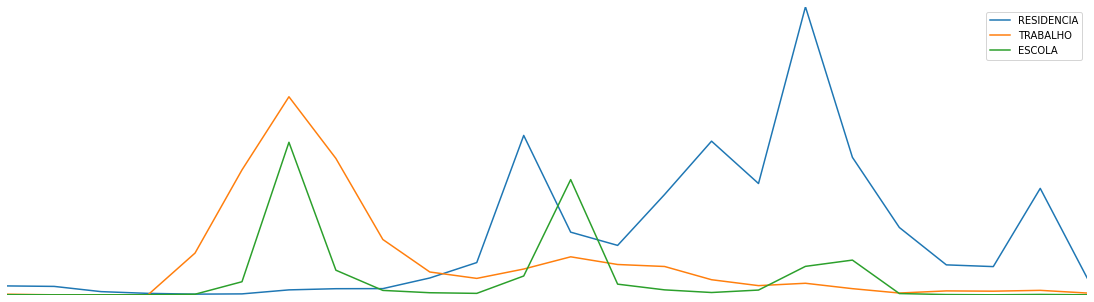

In [76]:
# GRÁFICO: Visualiza a quantidade de viagens por faixa

embarques_faixa_i.plot(x='HORA_I', y=['RESIDENCIA', 'TRABALHO', 'ESCOLA'], kind="line", figsize=(15,4), xticks=range(0,24))
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("D:\\OneDrive - cefetmg.br\\004.PC_servidor\\MMC-main\\embarques_faixa_i.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0)

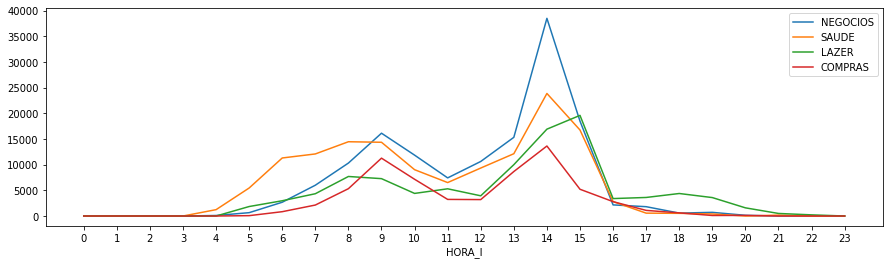

In [77]:
# GRÁFICO: Visualiza a quantidade de viagens por faixa

embarques_faixa_i.plot(x='HORA_I', y=['NEGOCIOS', 'SAUDE', 'LAZER', 'COMPRAS'], kind="line", figsize=(15,4), xticks=range(0,24))

In [78]:
# RELATÓRIO: Viagens atraídas por hora

embarques_faixa_f = pd.DataFrame({'RESIDENCIA':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Residência'].groupby('HORA_F')['FATOR_EXPANSÃO'].sum(),
                                'TRABALHO':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Trabalho'].groupby('HORA_F')['FATOR_EXPANSÃO'].sum(),
                                'ESCOLA':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Escola'].groupby('HORA_F')['FATOR_EXPANSÃO'].sum(),
                                'NEGOCIOS':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Negócios'].groupby('HORA_F')['FATOR_EXPANSÃO'].sum(),
                                'SAUDE':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Saúde'].groupby('HORA_F')['FATOR_EXPANSÃO'].sum(),
                                'LAZER':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Lazer'].groupby('HORA_F')['FATOR_EXPANSÃO'].sum(),
                                'OUTROS':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Outros'].groupby('HORA_F')['FATOR_EXPANSÃO'].sum(),
                                'COMPRAS':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Compras'].groupby('HORA_F')['FATOR_EXPANSÃO'].sum(),
                                'CARONA':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='carona'].groupby('HORA_F')['FATOR_EXPANSÃO'].sum(),
                                'REFEICAO':OD_2012_TC[OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Refeição'].groupby('HORA_F')['FATOR_EXPANSÃO'].sum()})

embarques_faixa_f['HORA_F']=embarques_faixa_f['RESIDENCIA'].index
pd.options.display.float_format='{:,.0f}'.format

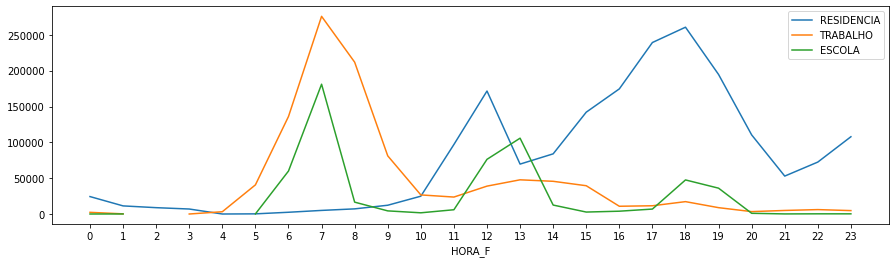

In [79]:
# GRÁFICO: Visualiza a quantidade de viagens pore faixa

embarques_faixa_f.plot(x='HORA_F', y=['RESIDENCIA', 'TRABALHO', 'ESCOLA'], kind="line", figsize=(15,4), xticks=range(0,24))

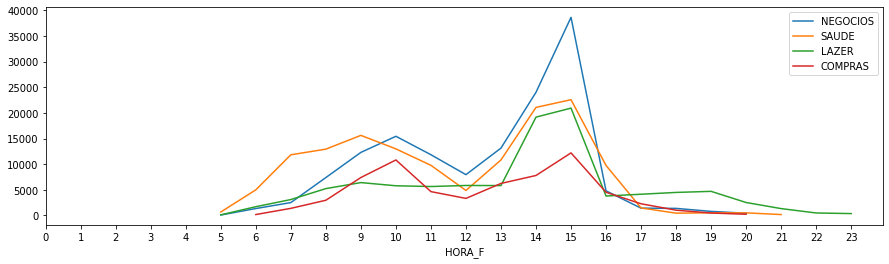

In [80]:
# GRÁFICO: Visualiza a quantidade de viagens pore faixa

embarques_faixa_f.plot(x='HORA_F', y=['NEGOCIOS', 'SAUDE', 'LAZER', 'COMPRAS'], kind="line", figsize=(15,4), xticks=range(0,24))

In [81]:
residencia = OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Residência'
OD_2012_TC_res = OD_2012_TC[residencia]

trabalho = OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Trabalho'
OD_2012_TC_tra = OD_2012_TC[trabalho]

escola = OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Escola'
OD_2012_TC_esc = OD_2012_TC[escola]

negocios = OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Negócios'
OD_2012_TC_neg = OD_2012_TC[negocios]

saude = OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Saúde'
OD_2012_TC_sau = OD_2012_TC[saude]

lazer = OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Lazer'
OD_2012_TC_laz = OD_2012_TC[lazer]

compras = OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Compras'
OD_2012_TC_com = OD_2012_TC[compras]

refeicao = OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Refeição'
OD_2012_TC_ref = OD_2012_TC[refeicao]

carona = OD_2012_TC['VERIFICAÇÃO_ESCALA']=='carona'
OD_2012_TC_car = OD_2012_TC[carona]

outros = OD_2012_TC['VERIFICAÇÃO_ESCALA']=='Outros'
OD_2012_TC_out = OD_2012_TC[outros]

In [82]:
pd.options.display.float_format='{:,.1f}'.format
OD_2012_TC_sau.describe()

,ID_DOMICILIO,ID_PESSOA,ID_VIAGEM,AH_ORIGEM,AH_DESTINO,FATOR_EXPANSÃO,DURACAO_ATIVIDADE,HORA_I,HORA_F,DURACAO_HR,DURACAO_PRODUTO,TEMPO_EMBARQUES_HR,TEMPO_EMBARQUES_PRODUTO
count,"1,048.0","1,048.0","1,048.0","1,048.0","1,048.0","1,048.0",1048,"1,048.0","1,048.0","1,048.0","1,048.0","1,048.0","1,048.0"
mean,"19,562.9",1.5,1.2,"5,559.3","3,390.7",134.5,0 days 02:21:14.370229007,10.0,11.0,2.4,272.8,3.5,409.8
std,"11,875.3",0.9,0.6,"6,554.8","4,915.9",260.7,0 days 02:35:55.397605631,3.4,3.3,2.6,478.5,2.7,597.0
min,12.0,1.0,1.0,"1,001.0","1,001.0",4.5,0 days 00:00:00,4.0,5.0,0.0,0.0,0.2,6.6
25%,"9,203.0",1.0,1.0,"1,412.0","1,018.0",66.1,0 days 00:55:00,7.0,8.0,0.9,75.5,2.0,162.2
50%,"18,732.5",1.0,1.0,"1,825.0","1,222.5",108.9,0 days 01:35:00,9.0,10.0,1.6,161.9,2.8,289.9
75%,"28,005.2",2.0,1.0,"5,326.0","2,025.5",146.4,0 days 03:00:00,13.0,14.0,3.0,319.9,4.2,490.7
max,"43,873.0",8.0,5.0,"32,102.0","30,006.0","4,071.1",0 days 23:35:00,21.0,21.0,23.6,"7,802.9",24.0,"10,177.7"


# Modelo 1

In [83]:
# Cria o DataFrame do modelo

DF_MODELO = pd.DataFrame({'MOTIVO':OD_2012_TC['VERIFICAÇÃO_ESCALA'],
                          'HORARIO_INICIO_VIAGEM':OD_2012_TC['HORARIO_INICIO'].dt.hour+OD_2012_TC['HORARIO_INICIO'].dt.minute/60+OD_2012_TC['HORARIO_INICIO'].dt.second/3600,
                          'TEMPO_ENTRE_EMBARQUES':OD_2012_TC['TEMPO_EMBARQUES_HR']})

pd.options.display.float_format='{:,.2f}'.format
DF_MODELO

,MOTIVO,HORARIO_INICIO_VIAGEM,TEMPO_ENTRE_EMBARQUES
0,Escola,11.75,1.33
1,Residência,13.08,22.67
2,Escola,17.00,5.67
3,Residência,22.67,18.33
6,Trabalho,5.75,7.25
...,...,...,...
139987,Residência,17.00,13.50
139996,Escola,5.67,5.92
139999,Residência,17.50,12.17
140000,Escola,12.67,4.75


In [84]:
# Verificando a distribuição de registros por motivo de viagem

y = DF_MODELO['MOTIVO'].values

counter = Counter(y)
counter

Counter({'Escola': 6703,
         'Residência': 18592,
         'Trabalho': 10099,
         'Refeição': 33,
         'Saúde': 1048,
         'Lazer': 751,
         'carona': 234,
         'Negócios': 931,
         'Compras': 557,
         'Outros': 750,
         nan: 1})

In [85]:
# Verifica e apaga casos com variável target nula

DF_MODELO_NaN = DF_MODELO[(DF_MODELO.MOTIVO.isnull())]
DF_MODELO_NaN

DF_MODELO = DF_MODELO.dropna()
print("DataFrame after removing rows with NaN value in All Columns:")
print(DF_MODELO)

DataFrame after removing rows with NaN value in All Columns:
            MOTIVO  HORARIO_INICIO_VIAGEM  TEMPO_ENTRE_EMBARQUES
0           Escola                  11.75                   1.33
1       Residência                  13.08                  22.67
2           Escola                  17.00                   5.67
3       Residência                  22.67                  18.33
6         Trabalho                   5.75                   7.25
...            ...                    ...                    ...
139987  Residência                  17.00                  13.50
139996      Escola                   5.67                   5.92
139999  Residência                  17.50                  12.17
140000      Escola                  12.67                   4.75
140001  Residência                  17.42                  19.25

[39698 rows x 3 columns]


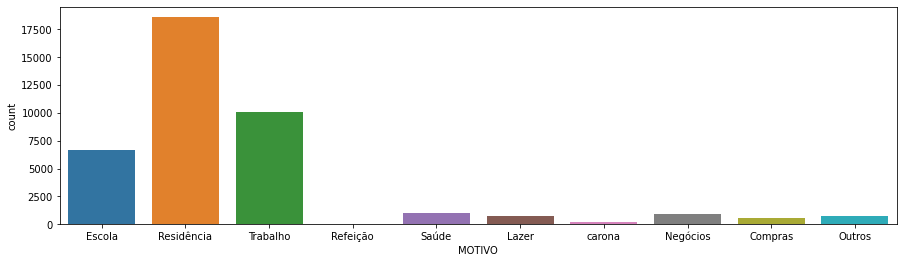

In [86]:
# Visualiza a distribuição do número de viagens por motivo

plt.figure(figsize=(18,12))
ax = sns.countplot(x="MOTIVO", data=DF_MODELO)
plt.gcf().set_size_inches(15, 4)

In [87]:
# Definindo as variáveis do modelo 

X_M1 = DF_MODELO.iloc[:,1:]
y_M1 = DF_MODELO['MOTIVO'].values

In [88]:
# Divide o DataFrame em treino teste
x1_training, x1_test, y1_training, y1_test = train_test_split(X_M1, y_M1, test_size = 0.2)

In [89]:
# Testa diferentes modelo de classificação

# Definindo os valores para o número de folds

num_folds = 10
num_instances = len(x1_training)
seed = 7

#Preparando os modelos
modelos = []
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('CART', DecisionTreeClassifier()))
modelos.append(('NB', GaussianNB()))
#modelos.append(('SVM', SVC()))
#modelos.append(('ADA', AdaBoostClassifier()))
#modelos.append(('GBM', GradientBoostingClassifier()))
modelos.append(('RF', RandomForestClassifier()))
#modelos.append(('XGB', xgb.XGBClassifier()))

KNN: 0.838750 (0.007319)
CART: 0.832231 (0.007767)
NB: 0.786574 (0.009240)
RF: 0.840765 (0.008556)


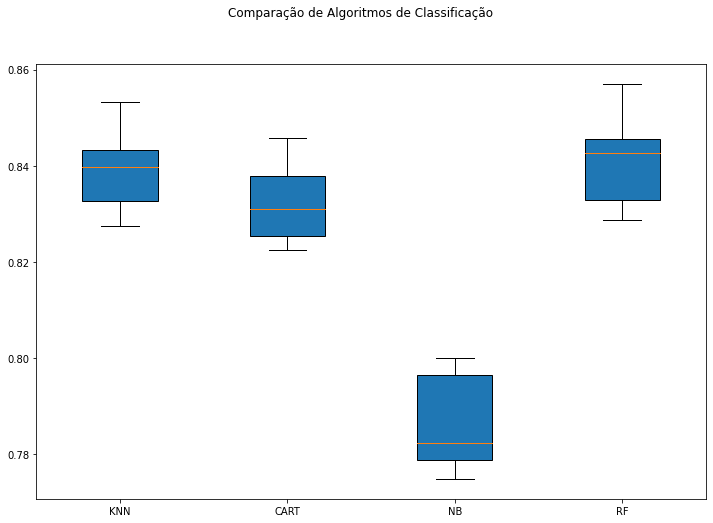

In [90]:
# Avaliando cada modelo
resultados = []
nomes = []

for nome, modelo in modelos:
    kfold = model_selection.KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(modelo, x1_training, y1_training, cv=kfold, scoring='accuracy')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %f (%f)" % (nome, cv_results.mean(), cv_results.std())
    print(msg)
    
# Boxplot para comparar os algoritmos
fig = plt.figure(figsize=(12,8))
fig.suptitle('Comparação de Algoritmos de Classificação')
ax = fig.add_subplot(111)
plt.boxplot(resultados, patch_artist=True)
ax.set_xticklabels(nomes)
plt.show()

In [91]:
# Matriz de confusão (modelo Random Forest)

num_folds = 10
num_instances = len(x1_training)
seed = 7

RF_1 = RandomForestClassifier()

In [92]:
kfold = model_selection.KFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = model_selection.cross_val_score(RF_1, x1_training, y1_training, cv=kfold, scoring='accuracy')

In [93]:
# Plot non-normalized confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
RF_1.fit(x1_training, y1_training)
previsao_RF = RF_1.predict(x1_test)

plt.figure(figsize=(1000, 1000))
cf_1 = confusion_matrix(y1_test, previsao_RF)
print(cf_1)


[[  14    8    5   32   10    0   14   23    9    0]
 [   2 1153   15   13    6    0   19   19  147    1]
 [   6   23   21   15    6    1   24   28   34    1]
 [  16    8    3   62   15    0   20   42    8    5]
 [   3   14    6   31   23    1   23   15   27   16]
 [   0    0    0    0    1    0    3    2    0    0]
 [   9   20    2   22   12    3 3554   15   44    6]
 [  16   36   13   43   11    0   19   77   24    5]
 [   2  131   14   13   13    1   53    9 1738    4]
 [   3    5    3    1   10    0    5    4    4    3]]
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fe36f6d7280> (for post_execute):


ValueError: ignored

<Figure size 72000x72000 with 0 Axes>

In [94]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Compras', 'Escola', 'Lazer', 'Negócios', 'Outros', 'Refeição', 'Residência', 'Saúde', 'Trabalho', 'Carona']


def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=False,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.set(font_scale = 1.2)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label', fontsize = 10)
        plt.xlabel('Predicted label' + stats_text, fontsize = 10)
    else:
        plt.xlabel(stats_text, fontsize = 10)
    
    if title:
        plt.title(title, fontsize = 10)

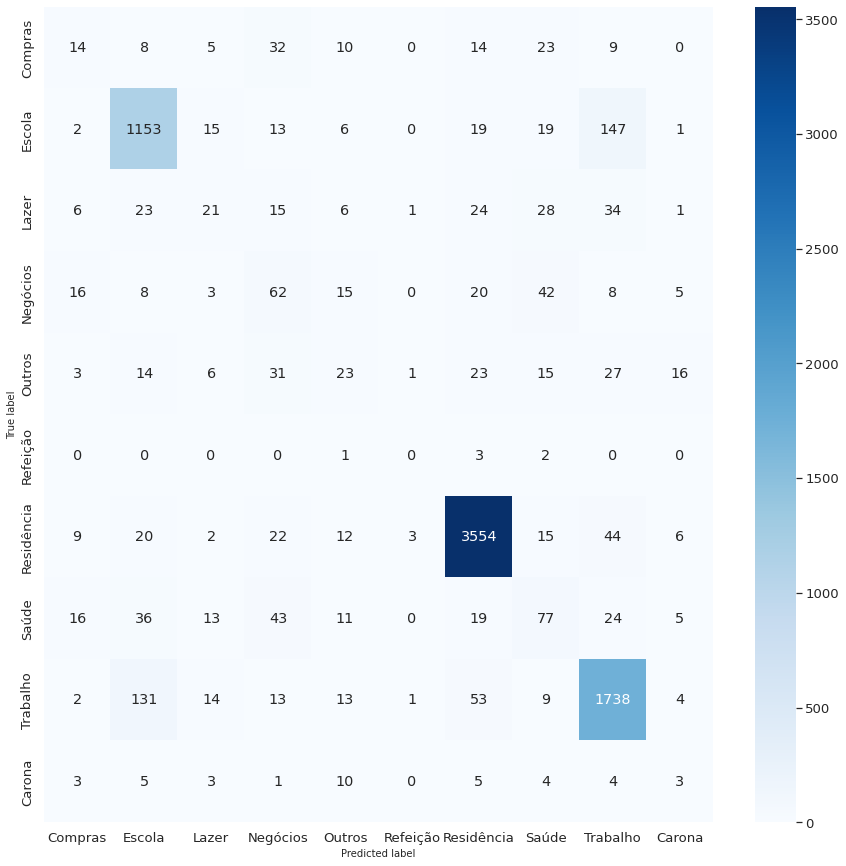

In [95]:
import seaborn as sns

make_confusion_matrix(cf_1, 
                      group_names=labels,
                      categories=categories,
                      figsize = (15,15),
                      cmap='Blues', sum_stats=False, count=True)



In [96]:
#predicting the data
y1_pred = RF_1.predict(x1_test)
y1_prob_pred = RF_1.predict_proba(x1_test)

In [97]:
print(classification_report(y1_test, y1_pred))

              precision    recall  f1-score   support

     Compras       0.20      0.12      0.15       115
      Escola       0.82      0.84      0.83      1375
       Lazer       0.26      0.13      0.17       159
    Negócios       0.27      0.35      0.30       179
      Outros       0.21      0.14      0.17       159
    Refeição       0.00      0.00      0.00         6
  Residência       0.95      0.96      0.96      3687
       Saúde       0.33      0.32      0.32       244
    Trabalho       0.85      0.88      0.87      1978
      carona       0.07      0.08      0.08        38

    accuracy                           0.84      7940
   macro avg       0.40      0.38      0.39      7940
weighted avg       0.83      0.84      0.83      7940



Este modelo apresentou métricas ruins, por isso um novo modelo será aplicado agrupando as atividades secundárias em uma categoria denominada "outros". Por serem atividades pouco representativas, elas estão incorporando ruídos ao modelo e deverão ser tratadas separadamente em outra etapa de modelagem ou considerando outros atributos, como por exemplo os Pontos de Interesse (POIs) como variáveis de uso e ocupação do solo.

# Modelo 2

In [98]:
DF_MODELO_2 = DF_MODELO

DF_MODELO_2['MOTIVO'] = DF_MODELO_2['MOTIVO'].map({'Residência':'Residência',
                                                   'Escola':'Escola',
                                                   'Trabalho':'Trabalho',
                                                   'Saúde':'Outros',
                                                   'Refeição': 'Outros', 
                                                   'Lazer':'Outros',
                                                   'Outros':'Outros',
                                                   'Compras':'Outros', 
                                                   'Negócios':'Outros',
                                                   'carona':'Outros'})

DF_MODELO_2

,MOTIVO,HORARIO_INICIO_VIAGEM,TEMPO_ENTRE_EMBARQUES
0,Escola,11.75,1.33
1,Residência,13.08,22.67
2,Escola,17.00,5.67
3,Residência,22.67,18.33
6,Trabalho,5.75,7.25
...,...,...,...
139987,Residência,17.00,13.50
139996,Escola,5.67,5.92
139999,Residência,17.50,12.17
140000,Escola,12.67,4.75


In [99]:
# Verificando a distribuição de registros por motivo de viagem

y_2 = DF_MODELO_2['MOTIVO'].values

counter_2 = Counter(y_2)
counter_2

Counter({'Escola': 6703,
         'Residência': 18592,
         'Trabalho': 10099,
         'Outros': 4304})

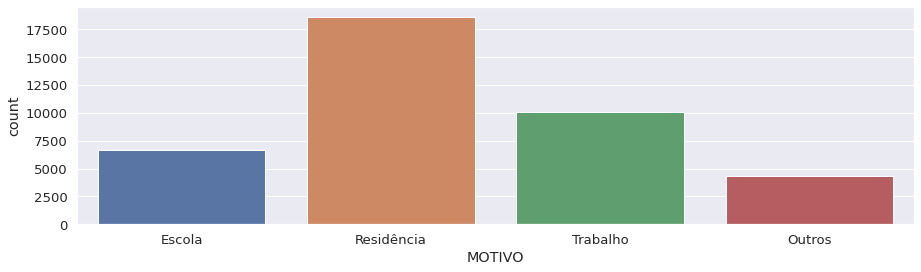

In [100]:
# Visualiza a distribuição do número de viagens por motivo

plt.figure(figsize=(18,12))
ax = sns.countplot(x="MOTIVO", data=DF_MODELO_2)
plt.gcf().set_size_inches(15, 4)

In [101]:
# Definindo as variáveis do modelo 

X_M2 = DF_MODELO_2.iloc[:,1:]
y_M2 = DF_MODELO_2['MOTIVO'].values

In [102]:
# Divide o DataFrame em treino teste
x2_training, x2_test, y2_training, y2_test = train_test_split(X_M2, y_M2, test_size = 0.2)

In [103]:
# Testa diferentes modelo de classificação

# Definindo os valores para o número de folds

num_folds = 10
num_instances = len(x2_training)
seed = 7

#Preparando os modelos
modelos_2 = []
modelos_2.append(('KNN', KNeighborsClassifier()))
modelos_2.append(('CART', DecisionTreeClassifier()))
modelos_2.append(('NB', GaussianNB()))
modelos_2.append(('RF', RandomForestClassifier()))


In [104]:
# Avaliando cada modelo
resultados_2 = []
nomes = []

for nome, modelo in modelos_2:
    kfold = model_selection.KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(modelo, x2_training, y2_training, cv=kfold, scoring='accuracy')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %f (%f)" % (nome, cv_results.mean(), cv_results.std())
    print(msg)
    

KNN: 0.894389 (0.005924)
CART: 0.882518 (0.006476)
NB: 0.834687 (0.007731)
RF: 0.892909 (0.006299)


In [105]:
# Matriz de confusão (modelo Random Forest)

num_folds = 10
num_instances = len(x2_training)
seed = 7

RF_2 = RandomForestClassifier()

In [106]:
kfold = model_selection.KFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = model_selection.cross_val_score(RF_2, x2_training, y2_training, cv=kfold, scoring='accuracy')

<Figure size 1440x1440 with 0 Axes>

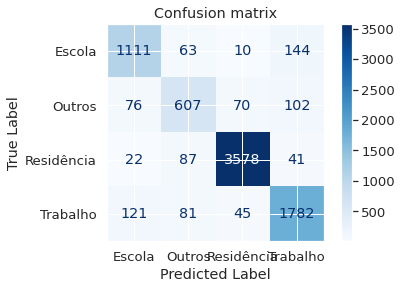

In [107]:
RF_2.fit(x2_training, y2_training)
previsao_RF = RF_2.predict(x2_test)

plt.figure(figsize=(20, 20))
plot_confusion_matrix(RF_2, x2_test, y2_test, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('teste.png', format='png' ,dpi = 300)
plt.show()


In [108]:
#predicting the data
y2_pred = RF_2.predict(x2_test)
y2_prob_pred = RF_2.predict_proba(x2_test)

In [111]:
# Plot non-normalized confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
RF_2.fit(x2_training, y2_training)
previsao_RF = RF_2.predict(x2_test)

plt.figure(figsize=(1000, 1000))
cf_2 = confusion_matrix(y2_test, previsao_RF)
print(cf_2);

[[1109   66    9  144]
 [  74  612   68  101]
 [  22   91 3573   42]
 [ 122   82   47 1778]]
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fe36f6d7280> (for post_execute):


ValueError: ignored

<Figure size 72000x72000 with 0 Axes>